# Income Profiles in Indian Tax Data
## August 22, 2019

This notebook walks through some exercises to look at hourly earnings profiles with Indian tax data.

It's important to note that Indian tax data *do not* contain any information on hours worked.  But when your an economist, you can just assume the can opener.  We'll assume that all workers follow the following age profile of hours worked:


Do the following:
1. Read in the `pitSmallData.csv` from the `taxcalc` repository.
2. Use the averaged hours worked in `/WB-India-2019/EarningsProfiles/hrs_by_age.csv` to compute hourly labor earnings for each record with a filer aged 20-80 in the tax data.  You will use just the aged 20-80 filers for the remaining exercises.
3. Find average hourly earnings by age.  Plot these average hourly earnings over age.
4. Now, for each age, break the earnings distribution into quartiles.  Compute the means for each age-quartile.  Plot these means over age.
5. Finally, for each quartile (but using individuals of all ages who are in that quartile), estimate the regression (where $i$ refers to the observation and $q$ to the quartile):
$$ ln(w_{i,q}) = \alpha_{q} + \beta_{1,q}age_{i,q} + \beta_{2,q}age_{i}^{2} + \beta_{4,q}age_{i,q}^{3} + \varepsilon_{i,q} $$
Put these regression coeffients in a table like:

|                | Q1 | Q2 | Q3 | Q4 |
|----------------|----|----|----|----|
| $\alpha$         |    |    |    |    |
| $\beta_{1}$         |    |    |    |    |
| $\beta_{2}$         |    |    |    |    |
| $\beta_{3}$         |    |    |    |    |
| Num Obs |    |    |    |    |

And plot the four earnings profiles from these parameter estimates.

In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

## Exercise 1

In [22]:
# Read in data
# You may need to change the path to the taxcalc directory
df_tax = pd.read_csv('../../taxcalc-India/taxcalc/pitSmallData.csv')
df_tax.keys()

Index(['FILING_SEQ_NO', 'AGE', 'AGEGRP', 'FORM_ID', 'ASSESSMENT_YEAR',
       'SALARIES', 'INCOME_HP', 'PRFT_GAIN_BP_OTHR_SPECLTV_BUS',
       'PRFT_GAIN_BP_SPECLTV_BUS', 'PRFT_GAIN_BP_SPCFD_BUS',
       'PRFT_GAIN_BP_INC_115BBF', 'TOTAL_PROFTS_GAINS_BP', 'ST_CG_AMT_1',
       'ST_CG_AMT_2', 'ST_CG_AMT_APPRATE', 'TOTAL_SCTG', 'LT_CG_AMT_1',
       'LT_CG_AMT_2', 'TOTAL_LTCG', 'TOTAL_CAP_GAIN',
       'INCOME_OS_NOT_RACEHORSE', 'INC_CHARBLE_SPL_RATE',
       'INCOME_OS_RACEHORSE', 'TOTAL_INCOME_OS', 'GTI_BEFORE_LOSSES',
       'CYL_SET_OFF', 'BAL_AFTR_CYL_SET_OFF', 'BFL_SET_OFF_BALANCE',
       'GROSS_TOTAL_INCOME', 'INC_CHG_TAX_SPL_RATES', 'DEDUCT_SEC_10A_OR_10AA',
       'PARTB_CHAPTER_VIA', 'PARTC_CHAPTER_VIA', 'TOTAL_DEDUC_VIA',
       'TOTAL_INCOME', 'INC_SPL_111A_112', 'NET_AGRC_INCOME',
       'AGGREGATE_INCOME', 'CY_LOSS_CARRYFWD', 'TAX_PAYBLE_TI_SEC115JC',
       'SURCHARGE_ON_DEEMED_TI', 'EDUCATION_CESS_SEC115JC',
       'TOTAL_TAX_PAYBL_SEC115JC', 'TAX_NORMAL_RATE', 'TAX_SI_R

## Exercise 2

Read in hours data, merge, and create hourly earnings.

In [3]:
# Define labor earnings
df_tax['labor_income'] = df_tax['SALARIES'] + df_tax['PRFT_GAIN_BP_OTHR_SPECLTV_BUS']
# merge in hours
df_hours = pd.read_csv('hrs_by_age.csv')
df1 = df_tax.merge(df_hours, how='left', left_on='AGE', right_on='age')
df_earn = df1[['age','labor_income', 'hours']].copy()
# compute hourly earnings and log hourly earnings
df_earn['wage'] = df_earn['labor_income'] / df_earn['hours']
df_earn['ln_wage'] = np.log(df_earn['wage'])
df_earn[['labor_income', 'hours', 'wage', 'age']].describe()

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,labor_income,hours,wage,age
count,1.000000e+04,9896.000000,9.896000e+03,9896.000000
mean,3.948432e+06,1600.718977,2.386191e+03,44.193614
std,3.921540e+07,164.545182,2.332420e+04,12.011183
min,0.000000e+00,902.000000,0.000000e+00,21.000000
25%,2.248768e+05,1620.000000,1.482908e+02,35.000000
50%,5.711270e+05,1650.000000,3.598027e+02,44.000000
75%,1.086940e+06,1680.000000,6.794200e+02,53.000000
max,2.972359e+09,1700.000000,1.758792e+06,80.000000


In [19]:
# drop outliers, outside age 20-80, etc
# drop wages outside of 3 SD's of mean
sd_w = df_earn['wage'].std()
mean_w = df_earn['wage'].mean()
df_earn = df_earn[df_earn['wage'] < mean_w + 3 * sd_w]
df_earn.query('hours >  0 & age <= 80 & age >= 21' +
              ' & wage > 0', inplace=True)

count    7377.000000
mean      549.230030
std       390.649711
min         0.355030
25%       274.046429
50%       442.056548
75%       705.171585
max      2245.778443
Name: wage, dtype: float64
count    7213.000000
mean      517.472894
std       332.002312
min         0.355030
25%       271.350920
50%       433.026220
75%       685.374251
max      1720.788785
Name: wage, dtype: float64


## Exercise 3

Plot mean hourly earnings by age.

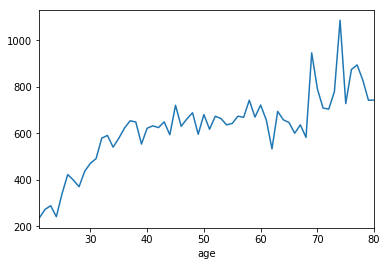

In [17]:
# compute means by age and plot
# df_earn.set_index('age', inplace=True)
df_earn.groupby('age')['wage'].mean().plot(x='age', y='wage')

## Exercise 4

Plot means by quartile by age.  Note that there are a couple ways to do this.  In the following, I find the distribution of wages at each age and then take of each quartile at each age.

In [6]:
# compute quartiles by age
# find percentile in distrubtion for each age
df_earn['wage_pct'] = df_earn.groupby('age')['wage'].rank(pct=True)
# Put in bins
groups = [0.0, 0.25, 0.5, 0.75, 1.0]
cats_pct = ['0-25', '26-50', '51-75', '75-100']
df_earn['q'] = pd.cut(df_earn['wage_pct'], groups, labels=False)
df_earn.describe()

,age,labor_income,hours,wage,ln_wage,wage_pct,q
count,7538.000000,7.538000e+03,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000
mean,44.265057,9.685596e+05,1604.816132,605.329548,6.109253,0.503980,1.506898
std,11.897390,8.836191e+05,155.657698,552.929753,0.783171,0.288719,1.118087
min,21.000000,6.000000e+02,902.000000,0.355030,-1.035554,0.003937,0.000000
25%,35.000000,4.408625e+05,1620.000000,276.487332,5.622165,0.253880,1.000000
50%,43.000000,7.204915e+05,1650.000000,451.612906,6.112825,0.503030,2.000000
75%,53.000000,1.173977e+06,1680.000000,726.664312,6.588465,0.753907,3.000000
max,80.000000,8.393249e+06,1700.000000,4996.337500,8.516460,1.000000,3.000000


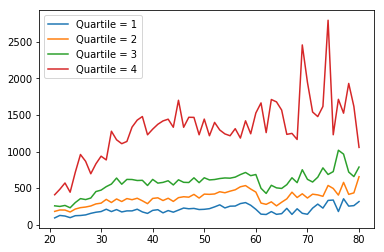

In [8]:
# plot by quartile
age = np.linspace(21, 80, 60)
for i in range(4):
    ydata = df_earn[df_earn['q']==i].groupby('age')['wage'].mean().values
    plt.plot(age, ydata, label='Quartile = ' + str(i + 1))
plt.legend()

## Exercise 5

Estimate regression models of the relationship between age and log wages.

In [24]:
# regressions by quartile
df_earn['age2'] = df_earn['age'] ** 2
df_earn['age3'] = df_earn['age'] ** 3
model_results = {
    'Names': ['Constant', '', 'Age', '', 'Age^2', '', 'Age^3', '',
              'R-Squared', 'Observations']}
long_model_results = {'Quartile': [], 'Constant': [],
                      'Age': [], 'Age^2': [], 'Age^3': [],
                      'Observations': []}
for i in range(4):
    data = df_earn[df_earn['q']==i]
    # run regression
    res = smf.ols('ln_wage ~ age + age2 + age3', data=data).fit()
    # Save model results to dictionary
    model_results['Q' + str(i + 1)] = [
        res.params['Intercept'],
        res.bse['Intercept'],
        res.params['age'], res.bse['age'],
        res.params['age2'], res.bse['age2'],
        res.params['age3'], res.bse['age3'],
        res.rsquared, res.nobs]
    long_model_results['Quartile'].append(i + 1)
    long_model_results['Constant'].append(res.params['Intercept'])
    long_model_results['Age'].append(res.params['age'])
    long_model_results['Age^2'].append(res.params['age2'])
    long_model_results['Age^3'].append(res.params['age3'])
    long_model_results['Observations'].append(res.nobs)

In [10]:
# put results in a table
results_df = pd.DataFrame(model_results)
results_df

,Names,Q1,Q2,Q3,Q4
0,Constant,2.275087,3.522676,1.565826,1.721977
1,,0.506987,0.158663,0.159477,0.364215
2,Age,0.159523,0.114236,0.282001,0.314390
3,,0.034051,0.010638,0.010707,0.024387
4,Age^2,-0.002748,-0.001717,-0.005328,-0.005960
5,,0.000729,0.000227,0.000229,0.000520
6,Age^3,0.000015,0.000008,0.000033,0.000037
7,,0.000005,0.000002,0.000002,0.000004
8,R-Squared,0.063920,0.488282,0.502998,0.193029
9,Observations,1864.000000,1894.000000,1875.000000,1905.000000


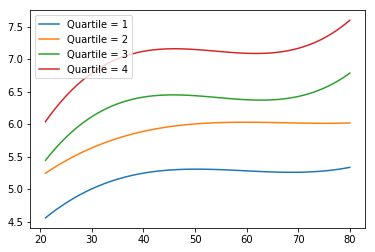

In [11]:
# plot results
for i in range(4):
    ydata = (long_model_results['Constant'][i] +
             long_model_results['Age'][i] * age +
             long_model_results['Age^2'][i] * age ** 2 +
             long_model_results['Age^3'][i] * age ** 3)
    plt.plot(age, ydata, label='Quartile = ' + str(i + 1))
plt.legend()
    